> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Week 1: Text Classification

### What are we building
We’ll continue to apply our learning philosophy of repetition as we build multiple classification models of increasing complexity in the following order:

1. Average of Word2Vec + MLP Layer
1. Can we concatenate 3 token embeddings and then average them? Does this do better than the previous method?
1. Build an embedding layer based model.
1. **Extension**: Explore different parameters, features and architectures. 

###  Evaluation
We’ll be evaluating our models on the following metric: 

1. Accuracy: is the ratio of the number of correctly classified instances to the total number of instances
1. **Extension**: this is a multi-class classification problem, visualize a [confusion matrix](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#confusion-matrix-func) of N*N of actual class vs predicted class (N = number of classes).


### Instructions

1. We've provide scaffolding for all the boiler plate PyTorch code to get to our first model. This covers downloading and parsing the dataset, training code for the baseline model. **Make sure to read all the steps and internalize what is happening**.
1. At this point our model gets to an accuracy of about 0.32. After this we'll try to improve the model by using sliding windows of text instead of just one word at a time. **Does this improve accuracy?**
1. The third model we're going to build is an embedding layer based model. Here instead of using pre-trained word-embeddings we'll be creating new vectors as part of the training process. **How do you think this model will perform?**
1. **Extension**: We've suggested a bunch of extensions to the project so go crazy, tweak any parts of the pipeline and see if you can beat all the current modes.

### Code Overview
- Dependencies: Python dependencies and loading the spacy model
- Project
  - Dataset: Download the conversation dataset and parse it into a pytorch Dataset
  - Trainer: Trainer function to help with multi-epoch training
  - Model 1: Simple Word2Vec + MLP model
  - Model 2: Sliding window trigram (Word2Vec)
  - Model 3: Embedding bag based model on Trigram
- Extensions
 


# Dependencies

✨ Now let's get started and to kick things off as always we install some dependencies.

In [2]:
%%capture
# Install all the required dependencies for the project
!pip install pytorch-lightning==1.6.5 spacy==2.2.4
!python -m spacy download en_core_web_md

Import all the necessary libraries we need throughout the project.

In [39]:
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
from collections import Counter
import en_core_web_md
import numpy as np
import pytorch_lightning as pl
import spacy
import torch
import torch.nn.functional as F
import torchmetrics
import pandas as pd
import collections

First things first, let's load the Spacy data which comes with pre-trainined embeddings. This process is expensive so only do this once.

In [4]:
# Really expensive operation to load the entire space word-vector index in memory
# We'll only run it once 
loaded_spacy_model = en_core_web_md.load()

Fix the random seed for numpy and pytorch so the entire class gets consistent results which we can discuss with each other.

In [5]:
# Fix the random seed so that we get consistent results
torch.manual_seed(0)
np.random.seed(0)

# Classifier Project 

✨ Let's Begin ✨

### Data Loading and Processing (Common to ALL Solutions)

#### Dataset

We’ll be using the Empathetic Dialogs dataset open-sourced by Facebook ([link](https://research.fb.com/publications/towards-empathetic-open-domain-conversation-models-a-new-benchmark-and-dataset/)). It can be downloaded as a tar ball from the following [link](https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz)

A sample row from the dataset: 
```
conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
hit:12388_conv:24777,1,joyful,I felt overcome with emotions when Christmas came around as a kid,437,Christmas was the best time of year back in the day!,5|5|5_5|5|5, ''
```

The three columns we'll primarily focus on are:
1. context ==> emotion we're trying to predict
1. prompt + utterance ==> We'll combine these sentences and use them as input 

But let's download and explore the dataset and these should automatically get clear.


In [6]:
import tarfile
import os
import csv

DIRECTORY_NAME="classification"
TRAIN_FILE="classification/empatheticdialogues/train.csv"
VALIDATION_FILE="classification/empatheticdialogues/valid.csv"
TEST_FILE="classification/empatheticdialogues/test.csv"


def download_dataset():
  """
  Download the dialog dataset. The tarball contains three files: train.csv, valid.csv, test.csv 
  """
  !wget 'https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz'
  if not os.path.isdir(DIRECTORY_NAME):
    !mkdir classification
  tar = tarfile.open('empatheticdialogues.tar.gz')
  tar.extractall(DIRECTORY_NAME)
  tar.close()

# Expensive operation so we should just do this once
download_dataset()

--2023-02-20 12:07:06--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz’

empatheticdialogues 100%[===================>]  26.72M  31.6MB/s    in 0.8s    

2023-02-20 12:07:07 (31.6 MB/s) - ‘empatheticdialogues.tar.gz’ saved [28022709/28022709]



Now the question is that did it do the right thing? Time to find out.


In [7]:
import glob
glob.glob(f"{DIRECTORY_NAME}/**/*.csv", recursive=True)

['classification/empatheticdialogues/test.csv',
 'classification/empatheticdialogues/train.csv',
 'classification/empatheticdialogues/valid.csv']

Cool we see all our files. Let's poke at one of them before we start parsing our dataset.

In [8]:
# See the parse_dataset function below for short explanation.
df = pd.read_csv(TRAIN_FILE, sep='\n', header=None)
df = df[0].str.split(',', expand=True)
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df.head(5)

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
1,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
2,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,
3,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,
4,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,
5,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,


The set of columns we care about are:
1. context ==> emotion we're trying to predict
1. prompt + utterance ==> We'll combine these sentences and use them as input 

Let's create a label encoder which converts our text labels to integer ids or vice versa

In [9]:
label_to_integer = dict()
integer_to_label = dict()

for ix, label in enumerate(df["context"].unique()):
  label_to_integer[label] = ix
  integer_to_label[ix] = label

Parse the dataset file and create a label encoder that converts text labels to integer ids or vice versa

In [10]:
def parse_dataset(file_path, sample=5000):
  # Our dataset file is a csv with varying input lengths, therefore we load the 
  # file at once, we have to split it up into separate steps:
  # 1. Read each row as a single column row
  df = pd.read_csv(file_path, sep = '\n', header = None)
  # 2. Split up each row into separate columns
  df = df[0].str.split(',', expand = True)
  # 3. Set the header by using the first row
  new_header = df.iloc[0]
  df = df[1:]
  df.columns = new_header

  # Machine learning cannot work with categorical labels like "suprised" or 
  # "excited". Therefore we convert these tokens into a number.
  df["target"] = df["context"].apply(lambda x: label_to_integer[x])
  df["feature"] = df["prompt"] + " " + df["utterance"]

  # We only need the column "**feature**" created from column 
  # "**prompt**" + "**utterance**" and the column "**target**".
  return df[["target", "feature"]].sample(n = sample, random_state = 0).values

Creating the global training, validation and test datasets from the data files. We've limited our sample size to speed up the training of the models. Originally these are the sizes of the dataset: 

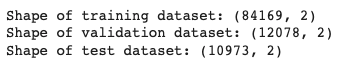

In [11]:
training_data = parse_dataset(TRAIN_FILE, sample = 40000)
validation_data = parse_dataset(VALIDATION_FILE, sample = 4000)
test_data = parse_dataset(TEST_FILE, sample = 4000)

print('Shape of training dataset: ({rows}, {cols})'.format(rows=len(training_data), cols=len(training_data[0])))
print('Shape of validation dataset: ({rows}, {cols})'.format(rows=len(validation_data), cols=len(validation_data[0])))
print('Shape of test dataset: ({rows}, {cols})'.format(rows=len(test_data), cols=len(test_data[0])))

Shape of training dataset: (40000, 2)
Shape of validation dataset: (4000, 2)
Shape of test dataset: (4000, 2)


[Dataset and Data loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html): Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

[LightingDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html#datamodules): A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data. A datamodule encapsulates the five steps involved in data processing in PyTorch:

1. Download / tokenize / process.
2. Clean and (maybe) save to disk.
3. Load inside Dataset.
4. Apply transforms (rotate, tokenize, etc…).
5. Wrap inside a DataLoader.


In [12]:
class ClassificationDataset(Dataset):
  """Creates an pytorch dataset to consume our pre-loaded csv data

  Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 
  """
  def __init__(self, data, vectorizer):
    self.dataset = data
    # Vectorizer needs to implement a vectorize function that returns vector and tokens
    # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
    self.vectorizer = vectorizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    (label, sentence) = self.dataset[idx]
    sentence_vector, sentence_tokens = self.vectorizer.vectorize(sentence)
    return {
        "vectors": sentence_vector,
        "label": label,
        "tokens": sentence_tokens, # for debugging only
        "sentence": sentence # for debugging only
      }

class ClassificationDataModule(pl.LightningDataModule):
  """LightningDataModule: Wrapper class for the dataset to be used in training
  """
  def __init__(self, vectorizer, params):
    super().__init__()
    self.params = params
    self.classification_train = ClassificationDataset(training_data, vectorizer)
    self.classification_val = ClassificationDataset(validation_data, vectorizer)
    self.classification_test = ClassificationDataset(test_data, vectorizer)

  # Function to convert the input raw data from the dataset into model input. 
  # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
  def collate_fn(self, batch):
    # Embedding layers need the inputs to be integer so we need to add this special case here.
    if self.params.integer_input: 
      word_vector = [torch.LongTensor(item["vectors"]) for item in batch]
      sentence_vector = pad_sequence(word_vector, batch_first=True, padding_value=0)
    else:
      sentence_vector = torch.stack([torch.Tensor(item["vectors"]) for item in batch])
    labels = torch.LongTensor([item["label"] for item in batch])
    return {"vectors": sentence_vector, "labels": labels, "sentences": [item["sentence"] for item in batch]}

  # Training dataloader .. will reset itself each epoch
  def train_dataloader(self):
    return DataLoader(self.classification_train, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

  # Validation dataloader .. will reset itself each epoch
  def val_dataloader(self):
    return DataLoader(self.classification_val, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

  # Test dataloader .. will reset itself each epoch
  def test_dataloader(self):
    return DataLoader(self.classification_test, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

### Classfier and Trainer (Common to all solutions)

We've now created the DataLoader and Datasets we'll use in the entire project.It is time to write the training and testing loops. 

[LightingModule](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html): organizes your PyTorch code into 5 sections

1. Computations (init).
2. Train loop (training_step)
3. Validation loop (validation_step)
4. Test loop (test_step)
5. Optimizers (configure_optimizers)

In [13]:
# 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
class EmotionClassifier(pl.LightningModule):
  def __init__(self, model, params):
      super().__init__()
      self.model = model
      self.params = params
      self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=params.num_classes)

  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
    x = batch["vectors"]
    y = batch["labels"]
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y, reduction='mean')
    self.log_dict(
        {'train_loss': loss}, 
        batch_size=self.params.batch_size, 
        prog_bar=True
        )
    return loss
  
  def validation_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["labels"]
    y_hat = self(x)
    val_loss = F.cross_entropy(y_hat, y, reduction='mean')
    predictions = torch.argmax(y_hat, dim=1)
    self.log_dict(
        {
          'val_loss': val_loss,
          'val_accuracy': self.accuracy(predictions, y)
        },
        batch_size=self.params.batch_size,  
        prog_bar=True
      )
    return val_loss

  def test_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["labels"]
    y_hat = self(x)
    test_loss = F.cross_entropy(y_hat, y, reduction='mean')
    predictions = torch.argmax(y_hat, dim=1)
    self.log_dict(
        {
          'test_loss': test_loss,
          'test_accuracy': self.accuracy(predictions, y)
        },
        batch_size=self.params.batch_size,  
        prog_bar=True
      )
    return test_loss
  
  def predict_step(self, batch, batch_idx):
    y_hat = self.model(batch["vectors"])
    predictions = torch.argmax(y_hat, dim=1)
    return {'logits':y_hat, 'predictions': predictions, 'labels': batch["labels"], 'sentences': batch['sentences']}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.params.learning_rate)
    return optimizer

Once we have a Lightning and LightingDataModule, a [Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) automates everything else. It provides functions for training (fit), testing and inference. We ended up writing a helper function that takes the model, vectorizer and hyper parameters to be able to easily compare our different models.

In [14]:
def trainer(model, params, vectorizer):
  # Create a pytorch trainer
  trainer = pl.Trainer(max_epochs=params.max_epochs, check_val_every_n_epoch=1)

  # Initialize our data loader with the passed vectorizer
  data_module = ClassificationDataModule(vectorizer, params)

  # Instantiate a new model
  model = EmotionClassifier(model, params)

  # Train and validate the model
  trainer.fit(model, data_module.train_dataloader(), val_dataloaders=data_module.val_dataloader())

  # Test the model
  trainer.test(model, data_module.test_dataloader())

  # Predict on the same test set to show some output
  output = trainer.predict(model, data_module.test_dataloader())

  for i in range(2):
    print("-----------")
    print("Sentence: ", output[1]['sentences'][i])
    print("Predicted Emotion: ", integer_to_label[output[1]['predictions'][i].item()])
    print("Actual Label: ", integer_to_label[output[1]['labels'][i].item()])

# Models

Are we building models yet? Finally the time has come to build our baseline model and then we'll work towards improving it. 

### Model 1: Average word vector of the sentence -- Baseline
##### <font color='red'>Expected accuracy: ~29 - 32%</font>

Let's build our first simple word2vec based model we'll use as our baseline.

Here we've three key pieces:

1. *WordVectorClassificationModel*: Simple linear model that just has one single neuron layer that maps the input word2vec dimensions (300) to the output classes (32) building a really simple classifier.

In [15]:
class WordVectorClassificationModel(torch.nn.Module):
  def __init__(self, word_vec_dimension, num_classes):
    super().__init__()
    self.classes = num_classes
    self.linear_layer = torch.nn.Linear(word_vec_dimension, num_classes)
    
  # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
  def forward(self, batch):
    """Projection from word_vec_dim to n_classes

    Batch is of shape (batch_size, max_seq_len, word_vector_dim)
    """
    return self.linear_layer(batch)

2. *HParams*: a class that contains all the hyper parameters relevant for the current model.
3. *SpacyVectorizer*: Vectorizer that converts the text sentence into the input to the DataLoader's collate function. Basically we'll call vectorizer on each row of the input data and then call the collate_fn on each batch of items which is fed to the Neural Network.

It will take several minutes to train the model, so don't be alarmed if you don't get the result right away. When the cell finishes running, under the `DATALOADER:0 TEST RESULTS` section, you should see the `test_accuracy` field with a value of ~0.3.

In [16]:
class HParams:
  batch_size: int = 32
  integer_input: bool = False
  word_vec_dimension: int = 300
  num_classes: int = 32
  learning_rate: float = 0.001
  max_epochs: int = 4


# 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
class SpacyVectorizer:
  def vectorize(self, sentence):
    """
    Given a sentence, tokenize it and reference pre-trained word vector for each token.

    Returns a tuple of sentence_vector and list of text tokens
    """
    sentence_vector = []
    sentence_tokens = []
    spacy_doc = loaded_spacy_model.make_doc(sentence) ## I am Sourabh
    word_vector = [token.vector for token in spacy_doc] ## [ [Embedding of I], [Embedding of am], [Embedding of UNK]] 
    sentence_tokens = list([token.text for token in spacy_doc])
    sentence_vector = np.mean(np.array(word_vector), axis=0)
    return sentence_vector, sentence_tokens


trainer(
    model=WordVectorClassificationModel(HParams.word_vec_dimension, 
                                        HParams.num_classes),
    params=HParams,
    vectorizer=SpacyVectorizer())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                          | Params
-----------------------------------------------------------
0 | model    | WordVectorClassificationModel | 9.6 K 
1 | accuracy | MulticlassAccuracy            | 0     
-----------------------------------------------------------
9.6 K     Trainable params
0         Non-trainable params
9.6 K     Total params
0.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3267500102519989
        test_loss            2.456451892852783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 1250it [00:00, ?it/s]

-----------
Sentence:  When I got falsely accused of eating my roommate's ice cream last night_comma_ I was completely outraged! I don't even eat ice cream because I'm lactose intolerant_comma_ and she knows that! I wonder who actually ate it then.
Predicted Emotion:  guilty
Actual Label:  furious
-----------
Sentence:  I found out that my childhood cat passed away yesterday  Thats sad. I love cats
Predicted Emotion:  sad
Actual Label:  sad


🎉🎉🎉 WE HAVE OUR TEXT CLASSIFIER 🎉🎉🎉


Now might be a good time to play around with the vectorizer and the classifier.

### Assignment Part: 1 - Model 2: Sliding Window Word2Vec ---- TO BE COMPLETED
##### <font color='red'>Expected accuracy: ~30 to 36%</font>

We'll be re-using the simple linear model from Model-1 but changing the input to use sliding windows instead of one word at a time. 

Implement a new `SpacyChunkVectorizer` which is a variant of the `SpacyVectorizer` that operates. Here are some instructions on how to implement it.

1. Split the sentence into chunks of the size of the n_grams parameter.
2. Concat all the spacy embeddings of the tokens inside to create embeddings of the chuck. Each chunk vector is of the size of `3 * size_of_embedding`
3. Sentence vector is the average of all chunk vectors.
4. Return the sentence_vector and tokens (for debugging, option: could just return None for tokens)

Does this model perform better than our baseline? Why do you think that is?

In [18]:
class HParamsSpacy:
  batch_size: int = 32
  integer_input: bool = False
  word_vec_dimension: int = 300
  num_classes: int = 32
  learning_rate: float = 0.001
  max_epochs: int = 4
  n_grams: int = 3  ## ADAPT, Change it to your liking
  


class SpacyChunkVectorizer:
  def __init__(self, params):
    self.params = params

  def split_into_ngrams(self, tokens):
      ngrams = []
      for i in range(len(tokens) - self.params.n_grams + 1):
          ngrams.append(tokens[i:i + self.params.n_grams])
      return ngrams
  
  def n_gram(self, tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

  def vectorize(self, sentence):
    """Given a sentence, tokenize it and returns a word vector for that sentence.

    Sentence is of length (n)

    1. Split the sentence into tokens using Spacy's function make_doc
    2. Split the list of token into size of the n_grams parameter.
    3. Concat all the spacy embeddings of the tokens inside to create embeddings of the chuck. Each chunk vector is of the size of 3 * size_of_embedding
    4. Sentence vector is the average of all chunk vectors.
    5. Return the sentence_vector and tokens (option: could just return None for tokens)

    Sentence_vector is of length (n_grams * word_vector_dim)
    Sentence_tokens is of length (n)

    Example of word tri-gram encoding: "I am doing great right now.":
      <EMPTY (300,)> <EMPTY (300,)> <I (300,)> -> (900, )
      <EMPTY (300,)> <I (300,)> <am (300,)> -> (900, )
      <I (300,)> <am (300,)> <doing (300,)> -> (900, )
      <am (300,)> <doing (300,)> <great (300,)> -> (900, )
      <doing (300,)> <great (300,)> <right (300,)> -> (900, )
      <great (300,)> <right (300,)> <now (300,)> -> (900, )
      <right (300,)> <now (300,)> <EMPTY (300,)> -> (900, )
      <now (300,)> <EMPTY (300,)> <EMPTY (300,)> -> (900, )

    We'd encourage you to also try other variants to encode!
    """
    ### TO BE IMPLEMENTED ###
    i = 0
    spacy_doc = loaded_spacy_model.make_doc(sentence)
    n_grams = self.n_gram([token for token in spacy_doc], self.params.n_grams)
    n_gram_vector = [np.concatenate(np.array([token.vector for token in n_gram]), axis=0) for n_gram in n_grams]
    if len(n_gram_vector) == 0:
      sentence_vector = np.zeros(self.params.n_grams * self.params.word_vec_dimension)
    else:
      sentence_vector = np.mean(np.array(n_gram_vector), axis=0)
    return sentence_vector, None


trainer(
    model=WordVectorClassificationModel(
        # Observe the change in input parameters
        HParamsSpacy.word_vec_dimension * HParamsSpacy.n_grams,  
        HParamsSpacy.num_classes),
    params=HParamsSpacy,
    vectorizer=SpacyChunkVectorizer(HParamsSpacy))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                          | Params
-----------------------------------------------------------
0 | model    | WordVectorClassificationModel | 28.8 K
1 | accuracy | MulticlassAccuracy            | 0     
-----------------------------------------------------------
28.8 K    Trainable params
0         Non-trainable params
28.8 K    Total params
0.115     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3630000054836273
        test_loss            2.21453595161438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 1250it [00:00, ?it/s]

-----------
Sentence:  When I got falsely accused of eating my roommate's ice cream last night_comma_ I was completely outraged! I don't even eat ice cream because I'm lactose intolerant_comma_ and she knows that! I wonder who actually ate it then.
Predicted Emotion:  ashamed
Actual Label:  furious
-----------
Sentence:  I found out that my childhood cat passed away yesterday  Thats sad. I love cats
Predicted Emotion:  sad
Actual Label:  sad


### Assignment Part: 2 - Model 3: EmbeddingBag  ---- TO BE COMPLETED
##### <font color='red'>Expected accuracy: ~32 to 38%</font>

The third model we're going to build is an embedding layer based model. Here instead of using pre-trained word-embeddings we'll be creating new vectors as part of the training process. How do you think this model will perform?

Implementation has the following steps:

1. **`get_char_trigram_token_map`**: Implement a map that returns top `num_tokens` token in the corpus to some allocated ids between `1 to num_tokens`. Here are some steps that should help with the implementation.
      1. Compute a frequency map of the `num_tokens` most common  character trigrams in the training data. **Note: We're now moving away from words and moving to just using characters directly**.
      3. Create unique integer ids for all these tokens 1...N

2. **Vectorizer**: Implement a new vectorizer for each sentence that does the following:
    1. Get all trigrams for the sentence
    2. Get id for every trigram
    4. Append all the ids into a list and that is your sentence vector

3. **Forward pass of the model**: Implement the forward pass of the model
    1. Pass the input batch through the embedding layer
    1. Pass the output of the embedding layer into our linear layer  


Some rational for trying this out is:
- We average the embeddings in a sentence anyway so word or not word maybe doesn't matter.
- Vocabalary of character trigrams is much smaller than word trigrams so our models are easier to train.

In [46]:
class HParamsCTT:
  batch_size: int = 16  ### NOTE THE CHANGE
  integer_input: bool = True  ### NOTE THE CHANGE
  num_classes: int = 32
  learning_rate: float = 0.001
  max_epochs: int = 4
  n_grams: int = 3
  embed_dim: int = 350 # ADDED, Change it to your liking
  num_tokens: int = 5000


class CharacterTrigramTokenizer:
  """
  We represent a sentence as a vector of num_tokens tokens.
  If the trigram is present in the sentence then we add the token's id to the sentence
  """
  def __init__(self, train_data, num_tokens):
    self.num_tokens = num_tokens
    self.token_to_id_map = self.get_char_trigram_token_map(train_data, num_tokens)

  def get_char_trigram_token_map(self, train_data, num_tokens):
    """
    1. Compute a frequency map of the `num_tokens` most common trigrams in the training data.
    2. Create unique integer ids for all these tokens 1...N
    """
    token_to_id_map = {}
    trigram_freq = collections.Counter()
    print_index = 0
    for sentence in train_data[:, 1]:
        for i in range(len(sentence) - 2):
            trigram = sentence[i:i+3]
            trigram_freq[trigram] += 1
            if print_index <= 10:
              print(trigram)
              print_index +=1

    top_trigrams = trigram_freq.most_common(num_tokens)
    for i, (trigram, _) in enumerate(top_trigrams):
        token_to_id_map[trigram] = i + 1
    


    ### TO BE IMPLEMENTED ###
    ...
    ### TO BE IMPLEMENTED ###


    return token_to_id_map
  
  def vectorize(self, sentence):
    """
    Given a sentence (string), do the following - 
    1. Get all trigrams for the sentence
    2. Get id for every trigram
    3. Append all the ids into a list and that is your sentence vector

    Example of the char tri-gram encoding: "How's going?":
      <EMPTY (300,)> <EMPTY (300,)> <H (300,)> -> (900, )
      <EMPTY (300,)> <H (300,)> <o (300,)> -> (900, )
      <H (300,)> <o (300,)> <w (300,)> -> (900, )
      <o (300,)> <w (300,)> <' (300,)> -> (900, )
      <w (300,)> <' (300,)> <s (300,)> -> (900, )
      <' (300,)> <s (300,)> <  (300,)> -> (900, )
      <s (300,)> <  (300,)> <g  (300,)> -> (900, )
      <  (300,)> <g (300,)> <o  (300,)> -> (900, )
      <g (300,)> <o (300,)> <i  (300,)> -> (900, )
      <o (300,)> <i (300,)> <n  (300,)> -> (900, )
      <i (300,)> <n (300,)> <g  (300,)> -> (900, )
      <n (300,)> <g (300,)> <?  (300,)> -> (900, )
      <g (300,)> <? (300,)> <EMPTY (300,)> -> (900, )
      <? (300,)> <EMPTY (300,)> <EMPTY (300,)> -> (900, )
    
    We'd encourage you to also try other variants to encode!
    """
    sentence_vector = []

    # Get all trigrams for the sentence
    trigrams = ["<EMPTY>", "<EMPTY>"] + [sentence[i:i+3] for i in range(len(sentence) - 2)]

    # Get id for every trigram
    for trigram in trigrams:
        if trigram in self.token_to_id_map:
            sentence_vector.append(self.token_to_id_map[trigram])
        else:
            sentence_vector.append(0)

    ### TO BE IMPLEMENTED ###
    ...
    ### TO BE IMPLEMENTED ###

    return sentence_vector, None

Let's just validate the output of the tokenizer before we train the model. We should see something like:

```
 I  1
 th 2
the 3
 to 4
ing 5
```

In [47]:
characterTokenizer = CharacterTrigramTokenizer(training_data, HParamsCTT.num_tokens)
i = 0
for k, v in characterTokenizer.token_to_id_map.items():
  if i >= 5:
    break
  print(k,v)
  i += 1


I f
 fo
for
org
rgo
got
ot 
t w
 wh
wha
hat
 th 1
 I  2
the 3
 to 4
ing 5


Now we can create the simple embedding layer based model and start training it.

In [48]:
class EmbeddingBagClassificationModel(torch.nn.Module):
  def __init__(self, num_tokens, embed_dim, n_classes):
    super().__init__()
    self.classes = n_classes
    self.embedding = torch.nn.EmbeddingBag(num_tokens, embed_dim)
    self.linear_layer = torch.nn.Linear(embed_dim, n_classes)
    
  def forward(self, batch):
    """Pass the input batch through the embedding layer and then follow it up with the linear layer
    """
    ### TO BE IMPLEMENTED ###
    ...
    ### TO BE IMPLEMENTED ###
    # Pass the inputs through the embedding layer
    embedded = self.embedding(batch)

    # Pass the embedded inputs through the linear layer
    y = self.linear_layer(embedded)
    return y


trainer(
    # Note the plus one: EmbeddingBag has 5000 + 1 tokens, where the +1 is
    # the padding embedding, which is a zero-vector.
    model=EmbeddingBagClassificationModel(
        HParamsCTT.num_tokens + 1, 
        HParamsCTT.embed_dim, 
        HParamsCTT.num_classes), 
    params=HParamsCTT,
    vectorizer=characterTokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                            | Params
-------------------------------------------------------------
0 | model    | EmbeddingBagClassificationModel | 1.8 M 
1 | accuracy | MulticlassAccuracy              | 0     
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.046     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3777500092983246
        test_loss            2.143181562423706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 2500it [00:00, ?it/s]

-----------
Sentence:  I am very hopeful to go on vacation this summer Summer can be over in July for teachers sometimes. Are you a teacher?
Predicted Emotion:  excited
Actual Label:  hopeful
-----------
Sentence:  I just built a warm fire and huddled up next to it until i started to fall asleep. I felt safe and secure I love a warm fire outside while camping! Sounds like a great time.
Predicted Emotion:  prepared
Actual Label:  content


🎉 CONGRATS!!! on finishing the assignment. Now is a good time to pause and reflect how much progress we've made in understanding word vectors, reading some pytorch code and build our first model. But hey, don't stop here, there is a lot to do or play with in the next sections.

# Extensions

Now that you've worked through the project. There is a lot more for us to try.

- Which model performed the best? Why do you think that was?
- Try decreasing and increasing the size of the dataset. How does that impact training time and accuracy of each model?
- Try adding a hidden layer to the baseline of the models and see if that changes anything
- Does adding a hidden layer to the embedding bag model help?
- visualize a [confusion matrix](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#confusion-matrix-func) of N*N of actual class vs predicted class (N = number of classes)